In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [181]:
from os.path import join
import numpy as np
from tqdm.auto import tqdm

rng_seed = 399
np.random.seed(rng_seed)
import persim
import joblib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Directory constants
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from topological_data_analysis.topological_polysemy import tps
from word_embeddings.word2vec import load_model_training_output

<IPython.core.display.Javascript object>

## Prepare data

In [3]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
    return_scann_instance=True,
)
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
last_embedding_weights_scann_instance = w2v_training_output[
    "last_embedding_weights_scann_instance"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

<IPython.core.display.Javascript object>

In [5]:
# Load SemEval data
semeval_2010_14_word_senses = joblib.load(
    join(
        root_code_dir,
        "topological_data_analysis",
        "data",
        "semeval_2010_14_word_senses.joblib",
    )
)

<IPython.core.display.Javascript object>

In [6]:
# Prepare data
semeval_target_word_tps_scores = {}

semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_target_words_in_vocab_filter = [
    i for i, word in enumerate(semeval_target_words) if word in word_to_int
]
semeval_target_words_in_vocab = semeval_target_words[
    semeval_target_words_in_vocab_filter
]
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))
semeval_gs_clusters_in_vocab = semeval_gs_clusters[semeval_target_words_in_vocab_filter]

num_semeval_words = len(semeval_gs_clusters_in_vocab)

<IPython.core.display.Javascript object>

In [7]:
# Compute TPS scores
tps_neighbourhood_size = 50
semeval_tps_scores = []
semeval_tps_pds = []
for semeval_target_word, semeval_target_word_clusters in tqdm(
    zip(semeval_target_words_in_vocab, semeval_gs_clusters_in_vocab),
    total=num_semeval_words,
):
    tps_score, tps_pd = tps(
        target_word=semeval_target_word,
        word_to_int=word_to_int,
        neighbourhood_size=tps_neighbourhood_size,
        word_embeddings_normalized=last_embedding_weights_normalized,
        ann_instance=last_embedding_weights_scann_instance,
        return_persistence_diagram=True,
    )
    semeval_tps_scores.append(tps_score)

    tps_pd_zero_dim = np.array(
        [
            [
                [birth, death]
                for dim, (birth, death) in tps_pd
                if dim == 0 and death != np.inf
            ]
        ]
    )
    semeval_tps_pds.append(tps_pd_zero_dim)
semeval_tps_scores = np.array(semeval_tps_scores)
semeval_tps_pds = np.array(semeval_tps_pds)

  0%|          | 0/98 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

## Do modeling

In [73]:
# Use zero-dim PD data points as features and num GS clusters as labels
data_X = semeval_tps_pds[:, 0, :, 1]
data_y = semeval_gs_clusters_in_vocab

<IPython.core.display.Javascript object>

In [83]:
# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    data_X,
    data_y,
    test_size=0.2,
    random_state=rng_seed,
)

<IPython.core.display.Javascript object>

In [169]:
def create_model(
    input_dim: int,
    num_hidden_layers: int,
    optimizer: tf.keras.optimizers.Optimizer,
    loss: str,
) -> Model:
    """
    TODO: Docs
    """
    # Input layer
    input_layer = Input(shape=(input_dim,), name="input")

    # Add hidden layers
    if num_hidden_layers > 0:
        dense_layer = Dense(input_dim // 2, activation=relu, name="hidden1")(
            input_layer
        )
        for i in range(1, num_hidden_layers):
            divisor = 2 ** (i + 1)
            dense_layer = Dense(
                input_dim // divisor, activation=relu, name=f"hidden{i + 1}"
            )(dense_layer)
    else:
        dense_layer = input_layer

    # Output layer
    output_layer = Dense(1, activation=relu, name="output")(dense_layer)

    # Create model and compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss)

    return model

<IPython.core.display.Javascript object>

In [205]:
wm_model = create_model(
    input_dim=X_train.shape[1],
    num_hidden_layers=0,
    optimizer=Adam(learning_rate=0.001),
    loss=MSE,
)
wm_model.summary()

# Fit model
wm_model_hist = wm_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=2,
    epochs=10000,
)


Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49)]              0         
_________________________________________________________________
output (Dense)               (None, 1)                 50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
39/39 [==============================] - 0s 3ms/step - loss: 24.9622 - val_loss: 25.6752
Epoch 2/10000
39/39 [==============================] - 0s 1ms/step - loss: 21.3784 - val_loss: 17.5104
Epoch 3/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.3576 - val_loss: 13.0999
Epoch 4/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.8512 - val_loss: 10.6015
Epoch 5/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.3228 - val_loss: 9.3043
Epoch 6/10

39/39 [==============================] - 0s 1ms/step - loss: 9.9061 - val_loss: 7.8855
Epoch 76/10000
39/39 [==============================] - 0s 1ms/step - loss: 11.9425 - val_loss: 7.8563
Epoch 77/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.7814 - val_loss: 7.8164
Epoch 78/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3078 - val_loss: 7.8839
Epoch 79/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2231 - val_loss: 7.7730
Epoch 80/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0295 - val_loss: 7.8553
Epoch 81/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2479 - val_loss: 7.8196
Epoch 82/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2619 - val_loss: 7.8677
Epoch 83/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.8767 - val_loss: 7.7368
Epoch 84/10000
39/39 [==============================] - 0s 1ms/step - loss: 11.1290 - val_loss:

39/39 [==============================] - 0s 1ms/step - loss: 11.5095 - val_loss: 7.5755
Epoch 155/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9283 - val_loss: 7.6984
Epoch 156/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.8592 - val_loss: 7.4908
Epoch 157/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.5946 - val_loss: 7.5653
Epoch 158/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3652 - val_loss: 7.5902
Epoch 159/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.9388 - val_loss: 7.5520
Epoch 160/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1125 - val_loss: 7.6636
Epoch 161/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.5536 - val_loss: 7.5356
Epoch 162/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0365 - val_loss: 7.6074
Epoch 163/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4852 - 

39/39 [==============================] - 0s 1ms/step - loss: 6.8803 - val_loss: 7.3105
Epoch 234/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7686 - val_loss: 7.3572
Epoch 235/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4555 - val_loss: 7.3138
Epoch 236/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0579 - val_loss: 7.4193
Epoch 237/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.8625 - val_loss: 7.3465
Epoch 238/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0326 - val_loss: 7.2973
Epoch 239/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3735 - val_loss: 7.4028
Epoch 240/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0740 - val_loss: 7.2914
Epoch 241/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0250 - val_loss: 7.2332
Epoch 242/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8566 - val

39/39 [==============================] - 0s 1ms/step - loss: 6.4110 - val_loss: 7.0853
Epoch 313/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1408 - val_loss: 7.1231
Epoch 314/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6861 - val_loss: 7.2303
Epoch 315/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9572 - val_loss: 7.1012
Epoch 316/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3549 - val_loss: 7.1664
Epoch 317/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1488 - val_loss: 7.1359
Epoch 318/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3298 - val_loss: 6.9884
Epoch 319/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3164 - val_loss: 7.2392
Epoch 320/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.8361 - val_loss: 7.1239
Epoch 321/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0068 - val

39/39 [==============================] - 0s 1ms/step - loss: 5.9970 - val_loss: 7.0831
Epoch 392/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7406 - val_loss: 6.9183
Epoch 393/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0883 - val_loss: 6.9019
Epoch 394/10000
39/39 [==============================] - 0s 9ms/step - loss: 7.3358 - val_loss: 7.0002
Epoch 395/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6663 - val_loss: 7.0123
Epoch 396/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1986 - val_loss: 6.9869
Epoch 397/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7233 - val_loss: 6.9182
Epoch 398/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5086 - val_loss: 6.8840
Epoch 399/10000
39/39 [==============================] - 0s 1ms/step - loss: 12.1228 - val_loss: 6.9660
Epoch 400/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3295 - va

39/39 [==============================] - 0s 1ms/step - loss: 8.4328 - val_loss: 6.7414
Epoch 471/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3082 - val_loss: 6.7912
Epoch 472/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4752 - val_loss: 6.8201
Epoch 473/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6794 - val_loss: 6.8385
Epoch 474/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1670 - val_loss: 6.8315
Epoch 475/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.5471 - val_loss: 6.7866
Epoch 476/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.5989 - val_loss: 6.7652
Epoch 477/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4894 - val_loss: 6.8395
Epoch 478/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.8328 - val_loss: 6.8211
Epoch 479/10000
39/39 [==============================] - 0s 9ms/step - loss: 7.1075 - val

39/39 [==============================] - 0s 1ms/step - loss: 8.3223 - val_loss: 6.6880
Epoch 550/10000
39/39 [==============================] - 0s 9ms/step - loss: 5.9502 - val_loss: 6.8006
Epoch 551/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4606 - val_loss: 6.5927
Epoch 552/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6564 - val_loss: 6.6749
Epoch 553/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.1139 - val_loss: 6.5898
Epoch 554/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3750 - val_loss: 6.7191
Epoch 555/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7720 - val_loss: 6.5741
Epoch 556/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6944 - val_loss: 6.6362
Epoch 557/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1360 - val_loss: 6.7141
Epoch 558/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.8564 - val

39/39 [==============================] - 0s 1ms/step - loss: 7.8643 - val_loss: 6.7068
Epoch 629/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0258 - val_loss: 6.5382
Epoch 630/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1307 - val_loss: 6.5525
Epoch 631/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4172 - val_loss: 6.6294
Epoch 632/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.5487 - val_loss: 6.5111
Epoch 633/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9366 - val_loss: 6.5875
Epoch 634/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8842 - val_loss: 6.5233
Epoch 635/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.8056 - val_loss: 6.5452
Epoch 636/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6054 - val_loss: 6.5672
Epoch 637/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6570 - val

39/39 [==============================] - 0s 1ms/step - loss: 9.0599 - val_loss: 6.4794
Epoch 708/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7124 - val_loss: 6.3233
Epoch 709/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.6247 - val_loss: 6.3949
Epoch 710/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7979 - val_loss: 6.5329
Epoch 711/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0670 - val_loss: 6.4308
Epoch 712/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2925 - val_loss: 6.4921
Epoch 713/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4531 - val_loss: 6.6050
Epoch 714/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.6948 - val_loss: 6.3735
Epoch 715/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.9075 - val_loss: 6.3666
Epoch 716/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5039 - va

39/39 [==============================] - 0s 1ms/step - loss: 8.0853 - val_loss: 6.3363
Epoch 787/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5222 - val_loss: 6.3707
Epoch 788/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.0566 - val_loss: 6.3385
Epoch 789/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.0990 - val_loss: 6.3745
Epoch 790/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8916 - val_loss: 6.4188
Epoch 791/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0687 - val_loss: 6.3917
Epoch 792/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2035 - val_loss: 6.3630
Epoch 793/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1150 - val_loss: 6.4013
Epoch 794/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9820 - val_loss: 6.4003
Epoch 795/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5726 - val

39/39 [==============================] - 0s 1ms/step - loss: 5.8646 - val_loss: 6.3325
Epoch 866/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7724 - val_loss: 6.2565
Epoch 867/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8758 - val_loss: 6.3064
Epoch 868/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0404 - val_loss: 6.2036
Epoch 869/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9677 - val_loss: 6.2038
Epoch 870/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5707 - val_loss: 6.3300
Epoch 871/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1564 - val_loss: 6.2142
Epoch 872/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2772 - val_loss: 6.2107
Epoch 873/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.6907 - val_loss: 6.2517
Epoch 874/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2450 - val

39/39 [==============================] - 0s 1ms/step - loss: 6.6799 - val_loss: 6.1922
Epoch 945/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0606 - val_loss: 6.2569
Epoch 946/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.6332 - val_loss: 6.1723
Epoch 947/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6707 - val_loss: 6.1970
Epoch 948/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9123 - val_loss: 6.1545
Epoch 949/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8036 - val_loss: 6.2132
Epoch 950/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3397 - val_loss: 6.2177
Epoch 951/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2685 - val_loss: 6.3272
Epoch 952/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2762 - val_loss: 6.0716
Epoch 953/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.6462 - va

39/39 [==============================] - 0s 1ms/step - loss: 4.9807 - val_loss: 6.1696
Epoch 1024/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9808 - val_loss: 6.1865
Epoch 1025/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3359 - val_loss: 5.9991
Epoch 1026/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5530 - val_loss: 6.1860
Epoch 1027/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3177 - val_loss: 6.1063
Epoch 1028/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0019 - val_loss: 6.0045
Epoch 1029/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7514 - val_loss: 6.0565
Epoch 1030/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6535 - val_loss: 6.2489
Epoch 1031/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7124 - val_loss: 6.1371
Epoch 1032/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.6

Epoch 1102/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4528 - val_loss: 6.1834
Epoch 1103/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4316 - val_loss: 5.9401
Epoch 1104/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4636 - val_loss: 6.1711
Epoch 1105/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0389 - val_loss: 6.1990
Epoch 1106/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6855 - val_loss: 6.0658
Epoch 1107/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4238 - val_loss: 6.0193
Epoch 1108/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7562 - val_loss: 6.0692
Epoch 1109/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8514 - val_loss: 6.1396
Epoch 1110/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7008 - val_loss: 6.1028
Epoch 1111/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 7.3381 - val_loss: 5.9704
Epoch 1181/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6965 - val_loss: 6.0042
Epoch 1182/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5497 - val_loss: 6.0292
Epoch 1183/10000
39/39 [==============================] - 0s 9ms/step - loss: 6.0860 - val_loss: 6.0580
Epoch 1184/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3872 - val_loss: 6.0318
Epoch 1185/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6288 - val_loss: 6.1042
Epoch 1186/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9737 - val_loss: 5.9784
Epoch 1187/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6329 - val_loss: 6.0328
Epoch 1188/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1770 - val_loss: 5.9020
Epoch 1189/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.6

Epoch 1259/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.5259 - val_loss: 6.1273
Epoch 1260/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4154 - val_loss: 5.9990
Epoch 1261/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4352 - val_loss: 6.0593
Epoch 1262/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1859 - val_loss: 5.9974
Epoch 1263/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5700 - val_loss: 5.9730
Epoch 1264/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6780 - val_loss: 6.0558
Epoch 1265/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7306 - val_loss: 5.9624
Epoch 1266/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6374 - val_loss: 5.9912
Epoch 1267/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9644 - val_loss: 5.8918
Epoch 1268/10000
39/39 [==============================] - 0s 9ms

39/39 [==============================] - 0s 1ms/step - loss: 6.2488 - val_loss: 5.9477
Epoch 1338/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2222 - val_loss: 5.9279
Epoch 1339/10000
39/39 [==============================] - 0s 9ms/step - loss: 6.0637 - val_loss: 5.8635
Epoch 1340/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7459 - val_loss: 5.9232
Epoch 1341/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4123 - val_loss: 5.9579
Epoch 1342/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3945 - val_loss: 5.9938
Epoch 1343/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8700 - val_loss: 5.9715
Epoch 1344/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9171 - val_loss: 5.9819
Epoch 1345/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8320 - val_loss: 6.0966
Epoch 1346/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2

Epoch 1416/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9692 - val_loss: 5.9000
Epoch 1417/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1298 - val_loss: 5.9313
Epoch 1418/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5421 - val_loss: 5.9998
Epoch 1419/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8212 - val_loss: 5.7854
Epoch 1420/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5014 - val_loss: 6.1133
Epoch 1421/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1912 - val_loss: 5.9871
Epoch 1422/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.8290 - val_loss: 5.7807
Epoch 1423/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8338 - val_loss: 6.0331
Epoch 1424/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1174 - val_loss: 5.9210
Epoch 1425/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.7664 - val_loss: 5.8667
Epoch 1495/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4143 - val_loss: 5.8268
Epoch 1496/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2565 - val_loss: 5.8833
Epoch 1497/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9760 - val_loss: 5.7941
Epoch 1498/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3638 - val_loss: 5.9019
Epoch 1499/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.8186 - val_loss: 5.9119
Epoch 1500/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1123 - val_loss: 5.9028
Epoch 1501/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5062 - val_loss: 5.8617
Epoch 1502/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3477 - val_loss: 5.9086
Epoch 1503/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9

Epoch 1573/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3538 - val_loss: 5.8779
Epoch 1574/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5753 - val_loss: 5.8550
Epoch 1575/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9936 - val_loss: 5.7983
Epoch 1576/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7709 - val_loss: 5.9842
Epoch 1577/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0947 - val_loss: 5.8026
Epoch 1578/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1075 - val_loss: 5.8208
Epoch 1579/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8991 - val_loss: 6.0046
Epoch 1580/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4831 - val_loss: 5.7958
Epoch 1581/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7315 - val_loss: 5.8645
Epoch 1582/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.7155 - val_loss: 5.7640
Epoch 1652/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9671 - val_loss: 5.9521
Epoch 1653/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9231 - val_loss: 5.7871
Epoch 1654/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7885 - val_loss: 5.6767
Epoch 1655/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0469 - val_loss: 5.9564
Epoch 1656/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0503 - val_loss: 5.6947
Epoch 1657/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7283 - val_loss: 5.7853
Epoch 1658/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7702 - val_loss: 5.7864
Epoch 1659/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3374 - val_loss: 5.8921
Epoch 1660/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8

Epoch 1730/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4687 - val_loss: 5.8168
Epoch 1731/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6411 - val_loss: 5.7516
Epoch 1732/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9757 - val_loss: 5.8058
Epoch 1733/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6073 - val_loss: 5.8127
Epoch 1734/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0492 - val_loss: 5.7295
Epoch 1735/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9684 - val_loss: 5.7929
Epoch 1736/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1232 - val_loss: 5.8369
Epoch 1737/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.8542 - val_loss: 5.8092
Epoch 1738/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8855 - val_loss: 5.6981
Epoch 1739/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.3116 - val_loss: 5.5832
Epoch 1809/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3210 - val_loss: 5.7881
Epoch 1810/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9687 - val_loss: 5.7735
Epoch 1811/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.6776 - val_loss: 5.7779
Epoch 1812/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4178 - val_loss: 5.8195
Epoch 1813/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.8490 - val_loss: 5.6886
Epoch 1814/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1470 - val_loss: 5.9187
Epoch 1815/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3964 - val_loss: 5.7499
Epoch 1816/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9675 - val_loss: 5.7944
Epoch 1817/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9

Epoch 1887/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4104 - val_loss: 5.7318
Epoch 1888/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3360 - val_loss: 5.7497
Epoch 1889/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3986 - val_loss: 5.7155
Epoch 1890/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8403 - val_loss: 5.7818
Epoch 1891/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2785 - val_loss: 5.8285
Epoch 1892/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3091 - val_loss: 5.7317
Epoch 1893/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3696 - val_loss: 5.8893
Epoch 1894/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7004 - val_loss: 5.7511
Epoch 1895/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1759 - val_loss: 5.6974
Epoch 1896/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.4582 - val_loss: 5.9562
Epoch 1966/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3264 - val_loss: 5.8480
Epoch 1967/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2295 - val_loss: 5.7739
Epoch 1968/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5491 - val_loss: 5.7263
Epoch 1969/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5765 - val_loss: 5.7221
Epoch 1970/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1330 - val_loss: 5.6713
Epoch 1971/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6811 - val_loss: 5.7375
Epoch 1972/10000
39/39 [==============================] - 0s 9ms/step - loss: 7.9081 - val_loss: 5.6715
Epoch 1973/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8631 - val_loss: 5.7706
Epoch 1974/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6

Epoch 2044/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.1286 - val_loss: 5.8060
Epoch 2045/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9116 - val_loss: 5.7747
Epoch 2046/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3444 - val_loss: 5.7295
Epoch 2047/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4569 - val_loss: 5.8589
Epoch 2048/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7751 - val_loss: 5.7572
Epoch 2049/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4604 - val_loss: 5.6741
Epoch 2050/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8757 - val_loss: 5.8271
Epoch 2051/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3113 - val_loss: 5.6425
Epoch 2052/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1017 - val_loss: 5.9638
Epoch 2053/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 5.3819 - val_loss: 5.6287
Epoch 2123/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5123 - val_loss: 5.7512
Epoch 2124/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2128 - val_loss: 5.5893
Epoch 2125/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9270 - val_loss: 5.6505
Epoch 2126/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3797 - val_loss: 5.8499
Epoch 2127/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9768 - val_loss: 5.7628
Epoch 2128/10000
39/39 [==============================] - 0s 9ms/step - loss: 6.1369 - val_loss: 5.7180
Epoch 2129/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5637 - val_loss: 5.6727
Epoch 2130/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.7572 - val_loss: 5.7951
Epoch 2131/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7

Epoch 2201/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4471 - val_loss: 5.9104
Epoch 2202/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0450 - val_loss: 5.7044
Epoch 2203/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8636 - val_loss: 5.5857
Epoch 2204/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0306 - val_loss: 5.6747
Epoch 2205/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1870 - val_loss: 5.7995
Epoch 2206/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5646 - val_loss: 5.6506
Epoch 2207/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8124 - val_loss: 5.5843
Epoch 2208/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7533 - val_loss: 5.5655
Epoch 2209/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3722 - val_loss: 5.6067
Epoch 2210/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 5.4278 - val_loss: 5.5611
Epoch 2280/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5906 - val_loss: 5.6770
Epoch 2281/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6980 - val_loss: 5.7413
Epoch 2282/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3122 - val_loss: 5.6061
Epoch 2283/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6565 - val_loss: 5.7964
Epoch 2284/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4130 - val_loss: 5.6340
Epoch 2285/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4860 - val_loss: 5.6856
Epoch 2286/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.7273 - val_loss: 5.7089
Epoch 2287/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5378 - val_loss: 5.6739
Epoch 2288/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1

Epoch 2358/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7364 - val_loss: 5.5763
Epoch 2359/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1793 - val_loss: 5.7572
Epoch 2360/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2341 - val_loss: 5.5615
Epoch 2361/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8682 - val_loss: 5.6710
Epoch 2362/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5996 - val_loss: 5.6899
Epoch 2363/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6118 - val_loss: 5.6580
Epoch 2364/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2671 - val_loss: 5.5954
Epoch 2365/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6745 - val_loss: 5.6382
Epoch 2366/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6848 - val_loss: 5.7260
Epoch 2367/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.7230 - val_loss: 5.6249
Epoch 2437/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6913 - val_loss: 5.5860
Epoch 2438/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6468 - val_loss: 5.6000
Epoch 2439/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4513 - val_loss: 5.7947
Epoch 2440/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2757 - val_loss: 5.6722
Epoch 2441/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3998 - val_loss: 5.7686
Epoch 2442/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5350 - val_loss: 5.5948
Epoch 2443/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5617 - val_loss: 5.6840
Epoch 2444/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3693 - val_loss: 5.6718
Epoch 2445/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4

Epoch 2515/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8376 - val_loss: 5.6563
Epoch 2516/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7518 - val_loss: 5.7245
Epoch 2517/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1871 - val_loss: 5.5324
Epoch 2518/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8299 - val_loss: 5.6172
Epoch 2519/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1700 - val_loss: 5.5779
Epoch 2520/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6266 - val_loss: 5.6333
Epoch 2521/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6366 - val_loss: 5.6580
Epoch 2522/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6082 - val_loss: 5.4917
Epoch 2523/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.4866 - val_loss: 5.7208
Epoch 2524/10000
39/39 [==============================] - 0s 1ms

Epoch 2594/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4078 - val_loss: 5.6057
Epoch 2595/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0675 - val_loss: 5.6935
Epoch 2596/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9018 - val_loss: 5.5337
Epoch 2597/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.8575 - val_loss: 5.8532
Epoch 2598/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2027 - val_loss: 5.6679
Epoch 2599/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7365 - val_loss: 5.6122
Epoch 2600/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9378 - val_loss: 5.5795
Epoch 2601/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9803 - val_loss: 5.6589
Epoch 2602/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6145 - val_loss: 5.5543
Epoch 2603/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.8653 - val_loss: 5.5762
Epoch 2673/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7392 - val_loss: 5.6876
Epoch 2674/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8883 - val_loss: 5.6747
Epoch 2675/10000
39/39 [==============================] - 0s 2ms/step - loss: 6.5581 - val_loss: 5.6397
Epoch 2676/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0828 - val_loss: 5.5424
Epoch 2677/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9993 - val_loss: 5.5746
Epoch 2678/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6472 - val_loss: 5.4214
Epoch 2679/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9754 - val_loss: 5.7206
Epoch 2680/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2119 - val_loss: 5.6161
Epoch 2681/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6

39/39 [==============================] - 0s 1ms/step - loss: 5.7483 - val_loss: 5.5317
Epoch 2751/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5179 - val_loss: 5.5897
Epoch 2752/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1331 - val_loss: 5.6625
Epoch 2753/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8720 - val_loss: 5.7630
Epoch 2754/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8252 - val_loss: 5.5476
Epoch 2755/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9069 - val_loss: 5.5652
Epoch 2756/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1794 - val_loss: 5.5847
Epoch 2757/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7876 - val_loss: 5.5149
Epoch 2758/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3399 - val_loss: 5.5735
Epoch 2759/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3

Epoch 2829/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0919 - val_loss: 5.5818
Epoch 2830/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0290 - val_loss: 5.7063
Epoch 2831/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0692 - val_loss: 5.5608
Epoch 2832/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5705 - val_loss: 5.6366
Epoch 2833/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4067 - val_loss: 5.6159
Epoch 2834/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9099 - val_loss: 5.5332
Epoch 2835/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3017 - val_loss: 5.5831
Epoch 2836/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4553 - val_loss: 5.5706
Epoch 2837/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1311 - val_loss: 5.6034
Epoch 2838/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 7.9305 - val_loss: 5.6233
Epoch 2908/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2754 - val_loss: 5.7067
Epoch 2909/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6580 - val_loss: 5.5604
Epoch 2910/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1040 - val_loss: 5.6390
Epoch 2911/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7650 - val_loss: 5.6262
Epoch 2912/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8311 - val_loss: 5.6630
Epoch 2913/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1962 - val_loss: 5.6015
Epoch 2914/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3539 - val_loss: 5.5415
Epoch 2915/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4753 - val_loss: 5.5862
Epoch 2916/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8

Epoch 2986/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5995 - val_loss: 5.5879
Epoch 2987/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5012 - val_loss: 5.5699
Epoch 2988/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1126 - val_loss: 5.5866
Epoch 2989/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0227 - val_loss: 5.5133
Epoch 2990/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.0215 - val_loss: 5.6636
Epoch 2991/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0716 - val_loss: 5.5338
Epoch 2992/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7927 - val_loss: 5.5860
Epoch 2993/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.0212 - val_loss: 5.6057
Epoch 2994/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6191 - val_loss: 5.6756
Epoch 2995/10000
39/39 [==============================] - 0s 1ms

Epoch 3065/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.9760 - val_loss: 5.5704
Epoch 3066/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7825 - val_loss: 5.6620
Epoch 3067/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6215 - val_loss: 5.5352
Epoch 3068/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8450 - val_loss: 5.6293
Epoch 3069/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2283 - val_loss: 5.6352
Epoch 3070/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9118 - val_loss: 5.5694
Epoch 3071/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2562 - val_loss: 5.7317
Epoch 3072/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3776 - val_loss: 5.6794
Epoch 3073/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9551 - val_loss: 5.5581
Epoch 3074/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 11.3953 - val_loss: 5.5272
Epoch 3144/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4956 - val_loss: 5.7737
Epoch 3145/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5133 - val_loss: 5.5355
Epoch 3146/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7083 - val_loss: 5.5814
Epoch 3147/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4212 - val_loss: 5.5823
Epoch 3148/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3291 - val_loss: 5.8982
Epoch 3149/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1760 - val_loss: 5.5265
Epoch 3150/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5699 - val_loss: 5.5075
Epoch 3151/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2328 - val_loss: 5.5316
Epoch 3152/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.

Epoch 3222/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3637 - val_loss: 5.5592
Epoch 3223/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5107 - val_loss: 5.5330
Epoch 3224/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5812 - val_loss: 5.7127
Epoch 3225/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5214 - val_loss: 5.6274
Epoch 3226/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8179 - val_loss: 5.5510
Epoch 3227/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8275 - val_loss: 5.6970
Epoch 3228/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4128 - val_loss: 5.4682
Epoch 3229/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5687 - val_loss: 5.4878
Epoch 3230/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5046 - val_loss: 5.6613
Epoch 3231/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.2921 - val_loss: 5.4964
Epoch 3301/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7827 - val_loss: 5.4861
Epoch 3302/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1410 - val_loss: 5.5678
Epoch 3303/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0907 - val_loss: 5.5544
Epoch 3304/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4627 - val_loss: 5.6724
Epoch 3305/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6717 - val_loss: 5.6392
Epoch 3306/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6870 - val_loss: 5.5912
Epoch 3307/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4516 - val_loss: 5.4689
Epoch 3308/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1963 - val_loss: 5.5486
Epoch 3309/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9

Epoch 3379/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4056 - val_loss: 5.5387
Epoch 3380/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8785 - val_loss: 5.6103
Epoch 3381/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2570 - val_loss: 5.5071
Epoch 3382/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2669 - val_loss: 5.7297
Epoch 3383/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8380 - val_loss: 5.4980
Epoch 3384/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6334 - val_loss: 5.4905
Epoch 3385/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8758 - val_loss: 5.6262
Epoch 3386/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2602 - val_loss: 5.5575
Epoch 3387/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8006 - val_loss: 5.5826
Epoch 3388/10000
39/39 [==============================] - 0s 1ms

Epoch 3458/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1795 - val_loss: 5.5428
Epoch 3459/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3831 - val_loss: 5.6237
Epoch 3460/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3192 - val_loss: 5.6067
Epoch 3461/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5754 - val_loss: 5.6237
Epoch 3462/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0083 - val_loss: 5.5441
Epoch 3463/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6312 - val_loss: 5.6181
Epoch 3464/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3274 - val_loss: 5.6609
Epoch 3465/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2657 - val_loss: 5.5522
Epoch 3466/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8819 - val_loss: 5.5314
Epoch 3467/10000
39/39 [==============================] - 0s 1ms

Epoch 3537/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6580 - val_loss: 5.6398
Epoch 3538/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.6976 - val_loss: 5.6051
Epoch 3539/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3278 - val_loss: 5.5376
Epoch 3540/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0718 - val_loss: 5.5785
Epoch 3541/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9887 - val_loss: 5.6703
Epoch 3542/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2854 - val_loss: 5.5720
Epoch 3543/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.6126 - val_loss: 5.5432
Epoch 3544/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6298 - val_loss: 5.7042
Epoch 3545/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.2110 - val_loss: 5.5912
Epoch 3546/10000
39/39 [==============================] - 0s 1ms

Epoch 3616/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6087 - val_loss: 5.5329
Epoch 3617/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8086 - val_loss: 5.4617
Epoch 3618/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1376 - val_loss: 5.5967
Epoch 3619/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6016 - val_loss: 5.6269
Epoch 3620/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5344 - val_loss: 5.5618
Epoch 3621/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6386 - val_loss: 5.5036
Epoch 3622/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8997 - val_loss: 5.5781
Epoch 3623/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7917 - val_loss: 5.6129
Epoch 3624/10000
39/39 [==============================] - 0s 2ms/step - loss: 7.1182 - val_loss: 5.5496
Epoch 3625/10000
39/39 [==============================] - 0s 1ms

Epoch 3695/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7308 - val_loss: 5.4830
Epoch 3696/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4110 - val_loss: 5.5136
Epoch 3697/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7232 - val_loss: 5.5316
Epoch 3698/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4700 - val_loss: 5.6039
Epoch 3699/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0505 - val_loss: 5.5450
Epoch 3700/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6817 - val_loss: 5.4682
Epoch 3701/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4518 - val_loss: 5.6171
Epoch 3702/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7572 - val_loss: 5.5131
Epoch 3703/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1256 - val_loss: 5.6699
Epoch 3704/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 7.5097 - val_loss: 5.5543
Epoch 3774/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9837 - val_loss: 5.4571
Epoch 3775/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6801 - val_loss: 5.6434
Epoch 3776/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5744 - val_loss: 5.4718
Epoch 3777/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0546 - val_loss: 5.6441
Epoch 3778/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8027 - val_loss: 5.4936
Epoch 3779/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8705 - val_loss: 5.4903
Epoch 3780/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.4238 - val_loss: 5.5162
Epoch 3781/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6577 - val_loss: 5.5796
Epoch 3782/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4

Epoch 3852/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2708 - val_loss: 5.6580
Epoch 3853/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6604 - val_loss: 5.4189
Epoch 3854/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4151 - val_loss: 5.5636
Epoch 3855/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6255 - val_loss: 5.5175
Epoch 3856/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5264 - val_loss: 5.5350
Epoch 3857/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6919 - val_loss: 5.4212
Epoch 3858/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0178 - val_loss: 5.5929
Epoch 3859/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9625 - val_loss: 5.4987
Epoch 3860/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8955 - val_loss: 5.5929
Epoch 3861/10000
39/39 [==============================] - 0s 1ms

Epoch 3931/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2610 - val_loss: 5.4920
Epoch 3932/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2021 - val_loss: 5.6267
Epoch 3933/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2698 - val_loss: 5.6225
Epoch 3934/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7946 - val_loss: 5.5412
Epoch 3935/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0708 - val_loss: 5.5559
Epoch 3936/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9571 - val_loss: 5.5314
Epoch 3937/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5537 - val_loss: 5.5521
Epoch 3938/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1760 - val_loss: 5.5696
Epoch 3939/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9546 - val_loss: 5.5406
Epoch 3940/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.8294 - val_loss: 5.4435
Epoch 4010/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.2582 - val_loss: 5.6066
Epoch 4011/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0552 - val_loss: 5.6431
Epoch 4012/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5012 - val_loss: 5.4167
Epoch 4013/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1601 - val_loss: 5.6734
Epoch 4014/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8295 - val_loss: 5.4884
Epoch 4015/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7471 - val_loss: 5.5645
Epoch 4016/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6086 - val_loss: 5.4696
Epoch 4017/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4444 - val_loss: 5.4778
Epoch 4018/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2

Epoch 4088/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4922 - val_loss: 5.4548
Epoch 4089/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0071 - val_loss: 5.6151
Epoch 4090/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9313 - val_loss: 5.6396
Epoch 4091/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6318 - val_loss: 5.5420
Epoch 4092/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1122 - val_loss: 5.5523
Epoch 4093/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5144 - val_loss: 5.4361
Epoch 4094/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.0340 - val_loss: 5.6956
Epoch 4095/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3271 - val_loss: 5.5461
Epoch 4096/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1353 - val_loss: 5.4966
Epoch 4097/10000
39/39 [==============================] - 0s 1ms

Epoch 4167/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9181 - val_loss: 5.5387
Epoch 4168/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5043 - val_loss: 5.7857
Epoch 4169/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.5242 - val_loss: 5.4278
Epoch 4170/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0959 - val_loss: 5.4568
Epoch 4171/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0534 - val_loss: 5.4561
Epoch 4172/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4537 - val_loss: 5.5670
Epoch 4173/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2120 - val_loss: 5.4901
Epoch 4174/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3191 - val_loss: 5.4320
Epoch 4175/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4451 - val_loss: 5.5653
Epoch 4176/10000
39/39 [==============================] - 0s 1ms

Epoch 4246/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9381 - val_loss: 5.6295
Epoch 4247/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7459 - val_loss: 5.4906
Epoch 4248/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3047 - val_loss: 5.5127
Epoch 4249/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2713 - val_loss: 5.5220
Epoch 4250/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0243 - val_loss: 5.6706
Epoch 4251/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0592 - val_loss: 5.4049
Epoch 4252/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3787 - val_loss: 5.5012
Epoch 4253/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3915 - val_loss: 5.5632
Epoch 4254/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5229 - val_loss: 5.6648
Epoch 4255/10000
39/39 [==============================] - 0s 1ms

Epoch 4325/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1176 - val_loss: 5.5501
Epoch 4326/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3054 - val_loss: 5.5390
Epoch 4327/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2769 - val_loss: 5.4294
Epoch 4328/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8473 - val_loss: 5.4920
Epoch 4329/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4943 - val_loss: 5.5136
Epoch 4330/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7072 - val_loss: 5.5827
Epoch 4331/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3636 - val_loss: 5.6718
Epoch 4332/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5569 - val_loss: 5.4719
Epoch 4333/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8396 - val_loss: 5.5956
Epoch 4334/10000
39/39 [==============================] - 0s 1ms

Epoch 4404/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0931 - val_loss: 5.6747
Epoch 4405/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1460 - val_loss: 5.4712
Epoch 4406/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4804 - val_loss: 5.4990
Epoch 4407/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.4967 - val_loss: 5.5127
Epoch 4408/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0515 - val_loss: 5.6045
Epoch 4409/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4627 - val_loss: 5.5399
Epoch 4410/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6403 - val_loss: 5.4857
Epoch 4411/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7770 - val_loss: 5.4980
Epoch 4412/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2605 - val_loss: 5.5257
Epoch 4413/10000
39/39 [==============================] - 0s 1ms

Epoch 4483/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8605 - val_loss: 5.5998
Epoch 4484/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7094 - val_loss: 5.5214
Epoch 4485/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5449 - val_loss: 5.5034
Epoch 4486/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.4667 - val_loss: 5.5728
Epoch 4487/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7557 - val_loss: 5.4495
Epoch 4488/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7083 - val_loss: 5.5524
Epoch 4489/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.9467 - val_loss: 5.6717
Epoch 4490/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2430 - val_loss: 5.4375
Epoch 4491/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6058 - val_loss: 5.4876
Epoch 4492/10000
39/39 [==============================] - 0s 1ms

Epoch 4562/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9730 - val_loss: 5.5317
Epoch 4563/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0981 - val_loss: 5.4641
Epoch 4564/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2397 - val_loss: 5.4555
Epoch 4565/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9722 - val_loss: 5.6698
Epoch 4566/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8616 - val_loss: 5.4652
Epoch 4567/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5379 - val_loss: 5.6516
Epoch 4568/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6407 - val_loss: 5.6389
Epoch 4569/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2733 - val_loss: 5.5645
Epoch 4570/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8315 - val_loss: 5.5367
Epoch 4571/10000
39/39 [==============================] - 0s 1ms

Epoch 4641/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7256 - val_loss: 5.4905
Epoch 4642/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4199 - val_loss: 5.5972
Epoch 4643/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9914 - val_loss: 5.4925
Epoch 4644/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8963 - val_loss: 5.4973
Epoch 4645/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7265 - val_loss: 5.5687
Epoch 4646/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8950 - val_loss: 5.5746
Epoch 4647/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3032 - val_loss: 5.4417
Epoch 4648/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0448 - val_loss: 5.5379
Epoch 4649/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7112 - val_loss: 5.4889
Epoch 4650/10000
39/39 [==============================] - 0s 1ms

Epoch 4720/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1855 - val_loss: 5.6201
Epoch 4721/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1189 - val_loss: 5.6504
Epoch 4722/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2215 - val_loss: 5.4846
Epoch 4723/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2419 - val_loss: 5.4840
Epoch 4724/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.8897 - val_loss: 5.5638
Epoch 4725/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7279 - val_loss: 5.5318
Epoch 4726/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9581 - val_loss: 5.6613
Epoch 4727/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1797 - val_loss: 5.4210
Epoch 4728/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0683 - val_loss: 5.5592
Epoch 4729/10000
39/39 [==============================] - 0s 1ms

Epoch 4799/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0360 - val_loss: 5.4701
Epoch 4800/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4620 - val_loss: 5.4894
Epoch 4801/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6023 - val_loss: 5.5120
Epoch 4802/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9866 - val_loss: 5.7247
Epoch 4803/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4686 - val_loss: 5.6103
Epoch 4804/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0995 - val_loss: 5.4987
Epoch 4805/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3252 - val_loss: 5.4815
Epoch 4806/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7411 - val_loss: 5.5481
Epoch 4807/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0461 - val_loss: 5.6077
Epoch 4808/10000
39/39 [==============================] - 0s 1ms

Epoch 4878/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3302 - val_loss: 5.4549
Epoch 4879/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8676 - val_loss: 5.6407
Epoch 4880/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7067 - val_loss: 5.5322
Epoch 4881/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5061 - val_loss: 5.5185
Epoch 4882/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8486 - val_loss: 5.5037
Epoch 4883/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9315 - val_loss: 5.5381
Epoch 4884/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7927 - val_loss: 5.3707
Epoch 4885/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8878 - val_loss: 5.4991
Epoch 4886/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1808 - val_loss: 5.4809
Epoch 4887/10000
39/39 [==============================] - 0s 1ms

Epoch 4957/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2795 - val_loss: 5.5237
Epoch 4958/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2257 - val_loss: 5.5088
Epoch 4959/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4819 - val_loss: 5.5339
Epoch 4960/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9363 - val_loss: 5.3968
Epoch 4961/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9175 - val_loss: 5.5467
Epoch 4962/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2510 - val_loss: 5.4826
Epoch 4963/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7384 - val_loss: 5.6917
Epoch 4964/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9917 - val_loss: 5.5149
Epoch 4965/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4825 - val_loss: 5.4740
Epoch 4966/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 4.5351 - val_loss: 5.5982
Epoch 5036/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2862 - val_loss: 5.4999
Epoch 5037/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7514 - val_loss: 5.6394
Epoch 5038/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6154 - val_loss: 5.3926
Epoch 5039/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9728 - val_loss: 5.5052
Epoch 5040/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2748 - val_loss: 5.5218
Epoch 5041/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0391 - val_loss: 5.5925
Epoch 5042/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2774 - val_loss: 5.4986
Epoch 5043/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2157 - val_loss: 5.3927
Epoch 5044/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5

Epoch 5114/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0308 - val_loss: 5.6647
Epoch 5115/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1022 - val_loss: 5.4781
Epoch 5116/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4810 - val_loss: 5.5896
Epoch 5117/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2879 - val_loss: 5.4318
Epoch 5118/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7293 - val_loss: 5.4462
Epoch 5119/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8808 - val_loss: 5.5358
Epoch 5120/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1078 - val_loss: 5.5155
Epoch 5121/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1160 - val_loss: 5.5414
Epoch 5122/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2110 - val_loss: 5.5912
Epoch 5123/10000
39/39 [==============================] - 0s 1ms

Epoch 5193/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7903 - val_loss: 5.5415
Epoch 5194/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8820 - val_loss: 5.3867
Epoch 5195/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9597 - val_loss: 5.4594
Epoch 5196/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4992 - val_loss: 5.5124
Epoch 5197/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0745 - val_loss: 5.4163
Epoch 5198/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7234 - val_loss: 5.4324
Epoch 5199/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4524 - val_loss: 5.4933
Epoch 5200/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3837 - val_loss: 5.5119
Epoch 5201/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3254 - val_loss: 5.5900
Epoch 5202/10000
39/39 [==============================] - 0s 1ms

Epoch 5272/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6133 - val_loss: 5.5745
Epoch 5273/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5778 - val_loss: 5.7494
Epoch 5274/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0555 - val_loss: 5.4764
Epoch 5275/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.5246 - val_loss: 5.5126
Epoch 5276/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7504 - val_loss: 5.4450
Epoch 5277/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.3753 - val_loss: 5.4671
Epoch 5278/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6825 - val_loss: 5.5919
Epoch 5279/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9772 - val_loss: 5.5255
Epoch 5280/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9904 - val_loss: 5.4331
Epoch 5281/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.0779 - val_loss: 5.5313
Epoch 5351/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1861 - val_loss: 5.5413
Epoch 5352/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0873 - val_loss: 5.4998
Epoch 5353/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2558 - val_loss: 5.4855
Epoch 5354/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7832 - val_loss: 5.5618
Epoch 5355/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5567 - val_loss: 5.5874
Epoch 5356/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0641 - val_loss: 5.4839
Epoch 5357/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7464 - val_loss: 5.4236
Epoch 5358/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6816 - val_loss: 5.5861
Epoch 5359/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1

Epoch 5429/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6925 - val_loss: 5.5261
Epoch 5430/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4578 - val_loss: 5.5565
Epoch 5431/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2164 - val_loss: 5.6103
Epoch 5432/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5290 - val_loss: 5.4747
Epoch 5433/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6530 - val_loss: 5.6034
Epoch 5434/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2355 - val_loss: 5.4522
Epoch 5435/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0703 - val_loss: 5.5238
Epoch 5436/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2110 - val_loss: 5.4436
Epoch 5437/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5058 - val_loss: 5.6230
Epoch 5438/10000
39/39 [==============================] - 0s 1ms

Epoch 5508/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0027 - val_loss: 5.6162
Epoch 5509/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4899 - val_loss: 5.4998
Epoch 5510/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8161 - val_loss: 5.5117
Epoch 5511/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2673 - val_loss: 5.6314
Epoch 5512/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4387 - val_loss: 5.4331
Epoch 5513/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6956 - val_loss: 5.5766
Epoch 5514/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6350 - val_loss: 5.6279
Epoch 5515/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2261 - val_loss: 5.3903
Epoch 5516/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4286 - val_loss: 5.6859
Epoch 5517/10000
39/39 [==============================] - 0s 1ms

Epoch 5587/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1919 - val_loss: 5.5841
Epoch 5588/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8682 - val_loss: 5.4043
Epoch 5589/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8483 - val_loss: 5.5182
Epoch 5590/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.1539 - val_loss: 5.5597
Epoch 5591/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5801 - val_loss: 5.5823
Epoch 5592/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8053 - val_loss: 5.5704
Epoch 5593/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7334 - val_loss: 5.4303
Epoch 5594/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7603 - val_loss: 5.5684
Epoch 5595/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0465 - val_loss: 5.4919
Epoch 5596/10000
39/39 [==============================] - 0s 1ms

Epoch 5666/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3321 - val_loss: 5.6255
Epoch 5667/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8393 - val_loss: 5.3974
Epoch 5668/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1701 - val_loss: 5.5999
Epoch 5669/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3412 - val_loss: 5.4330
Epoch 5670/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0940 - val_loss: 5.4968
Epoch 5671/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0011 - val_loss: 5.5078
Epoch 5672/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0780 - val_loss: 5.6155
Epoch 5673/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5146 - val_loss: 5.4541
Epoch 5674/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.1876 - val_loss: 5.5572
Epoch 5675/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 7.2876 - val_loss: 5.3992
Epoch 5745/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7748 - val_loss: 5.6447
Epoch 5746/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2135 - val_loss: 5.4474
Epoch 5747/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6275 - val_loss: 5.5897
Epoch 5748/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6868 - val_loss: 5.5414
Epoch 5749/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0274 - val_loss: 5.4374
Epoch 5750/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8938 - val_loss: 5.5939
Epoch 5751/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6443 - val_loss: 5.5083
Epoch 5752/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2162 - val_loss: 5.4740
Epoch 5753/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3

Epoch 5823/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7040 - val_loss: 5.6183
Epoch 5824/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7868 - val_loss: 5.4536
Epoch 5825/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9613 - val_loss: 5.5844
Epoch 5826/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1641 - val_loss: 5.4650
Epoch 5827/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8668 - val_loss: 5.5630
Epoch 5828/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0873 - val_loss: 5.5912
Epoch 5829/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9728 - val_loss: 5.5903
Epoch 5830/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7576 - val_loss: 5.4776
Epoch 5831/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8119 - val_loss: 5.4261
Epoch 5832/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.7985 - val_loss: 5.4706
Epoch 5902/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2211 - val_loss: 5.5289
Epoch 5903/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8386 - val_loss: 5.5253
Epoch 5904/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3372 - val_loss: 5.5942
Epoch 5905/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7825 - val_loss: 5.4592
Epoch 5906/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5630 - val_loss: 5.5422
Epoch 5907/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.1105 - val_loss: 5.5384
Epoch 5908/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4964 - val_loss: 5.5316
Epoch 5909/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7350 - val_loss: 5.6069
Epoch 5910/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3

Epoch 5980/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8484 - val_loss: 5.4596
Epoch 5981/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4919 - val_loss: 5.5030
Epoch 5982/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7733 - val_loss: 5.5378
Epoch 5983/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3880 - val_loss: 5.5612
Epoch 5984/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2060 - val_loss: 5.4729
Epoch 5985/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9220 - val_loss: 5.6429
Epoch 5986/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8449 - val_loss: 5.5998
Epoch 5987/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0890 - val_loss: 5.4386
Epoch 5988/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9669 - val_loss: 5.4603
Epoch 5989/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 9.3815 - val_loss: 5.4585
Epoch 6059/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1472 - val_loss: 5.5378
Epoch 6060/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2276 - val_loss: 5.6253
Epoch 6061/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7650 - val_loss: 5.5878
Epoch 6062/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6712 - val_loss: 5.4809
Epoch 6063/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5812 - val_loss: 5.5021
Epoch 6064/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6273 - val_loss: 5.4763
Epoch 6065/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7600 - val_loss: 5.6030
Epoch 6066/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6907 - val_loss: 5.4656
Epoch 6067/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7

Epoch 6137/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5220 - val_loss: 5.5480
Epoch 6138/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5238 - val_loss: 5.6242
Epoch 6139/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5309 - val_loss: 5.4929
Epoch 6140/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5449 - val_loss: 5.5288
Epoch 6141/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1183 - val_loss: 5.5533
Epoch 6142/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2502 - val_loss: 5.5461
Epoch 6143/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1689 - val_loss: 5.4279
Epoch 6144/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8840 - val_loss: 5.4839
Epoch 6145/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5371 - val_loss: 5.6304
Epoch 6146/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.0499 - val_loss: 5.4539
Epoch 6216/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3009 - val_loss: 5.5072
Epoch 6217/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3817 - val_loss: 5.4616
Epoch 6218/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3139 - val_loss: 5.5237
Epoch 6219/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9163 - val_loss: 5.4929
Epoch 6220/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8547 - val_loss: 5.5946
Epoch 6221/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7641 - val_loss: 5.5874
Epoch 6222/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0377 - val_loss: 5.4724
Epoch 6223/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9142 - val_loss: 5.4679
Epoch 6224/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2

Epoch 6294/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2092 - val_loss: 5.6187
Epoch 6295/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4313 - val_loss: 5.3781
Epoch 6296/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7647 - val_loss: 5.5008
Epoch 6297/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2583 - val_loss: 5.6110
Epoch 6298/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4693 - val_loss: 5.4213
Epoch 6299/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9472 - val_loss: 5.5043
Epoch 6300/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2646 - val_loss: 5.5416
Epoch 6301/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2571 - val_loss: 5.4681
Epoch 6302/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6187 - val_loss: 5.5574
Epoch 6303/10000
39/39 [==============================] - 0s 1ms

Epoch 6373/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4777 - val_loss: 5.4197
Epoch 6374/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9149 - val_loss: 5.4772
Epoch 6375/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3636 - val_loss: 5.5172
Epoch 6376/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7786 - val_loss: 5.6524
Epoch 6377/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8776 - val_loss: 5.4263
Epoch 6378/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6452 - val_loss: 5.5680
Epoch 6379/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5156 - val_loss: 5.6085
Epoch 6380/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3366 - val_loss: 5.5591
Epoch 6381/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7266 - val_loss: 5.4710
Epoch 6382/10000
39/39 [==============================] - 0s 1ms

Epoch 6452/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6538 - val_loss: 5.5813
Epoch 6453/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0498 - val_loss: 5.5307
Epoch 6454/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8953 - val_loss: 5.6185
Epoch 6455/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5541 - val_loss: 5.5338
Epoch 6456/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2158 - val_loss: 5.5104
Epoch 6457/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5661 - val_loss: 5.5017
Epoch 6458/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3701 - val_loss: 5.5400
Epoch 6459/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0417 - val_loss: 5.4045
Epoch 6460/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5897 - val_loss: 5.6455
Epoch 6461/10000
39/39 [==============================] - 0s 1ms

Epoch 6531/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7076 - val_loss: 5.5320
Epoch 6532/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7739 - val_loss: 5.5589
Epoch 6533/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8927 - val_loss: 5.4994
Epoch 6534/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8710 - val_loss: 5.5554
Epoch 6535/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7330 - val_loss: 5.6249
Epoch 6536/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4487 - val_loss: 5.4285
Epoch 6537/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9323 - val_loss: 5.5713
Epoch 6538/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8162 - val_loss: 5.3991
Epoch 6539/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3765 - val_loss: 5.5851
Epoch 6540/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 8.3996 - val_loss: 5.6079
Epoch 6610/10000
39/39 [==============================] - 0s 1ms/step - loss: 10.4972 - val_loss: 5.6166
Epoch 6611/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3789 - val_loss: 5.4026
Epoch 6612/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.9752 - val_loss: 5.6043
Epoch 6613/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3387 - val_loss: 5.5800
Epoch 6614/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3717 - val_loss: 5.6170
Epoch 6615/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1414 - val_loss: 5.4966
Epoch 6616/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3413 - val_loss: 5.5577
Epoch 6617/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0977 - val_loss: 5.6072
Epoch 6618/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.

Epoch 6688/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9638 - val_loss: 5.4967
Epoch 6689/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7521 - val_loss: 5.5185
Epoch 6690/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.7904 - val_loss: 5.4903
Epoch 6691/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8106 - val_loss: 5.4690
Epoch 6692/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4880 - val_loss: 5.4758
Epoch 6693/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6331 - val_loss: 5.5858
Epoch 6694/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3923 - val_loss: 5.5131
Epoch 6695/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0300 - val_loss: 5.5205
Epoch 6696/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8688 - val_loss: 5.4636
Epoch 6697/10000
39/39 [==============================] - 0s 1ms

Epoch 6767/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0968 - val_loss: 5.5181
Epoch 6768/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.0481 - val_loss: 5.5307
Epoch 6769/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0197 - val_loss: 5.5156
Epoch 6770/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1956 - val_loss: 5.6430
Epoch 6771/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3802 - val_loss: 5.6098
Epoch 6772/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8611 - val_loss: 5.4080
Epoch 6773/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4853 - val_loss: 5.5341
Epoch 6774/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.6669 - val_loss: 5.5728
Epoch 6775/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8243 - val_loss: 5.4531
Epoch 6776/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.0764 - val_loss: 5.4214
Epoch 6846/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8683 - val_loss: 5.5896
Epoch 6847/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1789 - val_loss: 5.6307
Epoch 6848/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0567 - val_loss: 5.5588
Epoch 6849/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2153 - val_loss: 5.5010
Epoch 6850/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6364 - val_loss: 5.6153
Epoch 6851/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6702 - val_loss: 5.5379
Epoch 6852/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5755 - val_loss: 5.6231
Epoch 6853/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4728 - val_loss: 5.4696
Epoch 6854/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0

Epoch 6924/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4506 - val_loss: 5.5552
Epoch 6925/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0401 - val_loss: 5.5459
Epoch 6926/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6672 - val_loss: 5.4876
Epoch 6927/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9958 - val_loss: 5.5049
Epoch 6928/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1183 - val_loss: 5.4464
Epoch 6929/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.9072 - val_loss: 5.6296
Epoch 6930/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.9890 - val_loss: 5.5786
Epoch 6931/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3196 - val_loss: 5.5397
Epoch 6932/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9010 - val_loss: 5.4911
Epoch 6933/10000
39/39 [==============================] - 0s 1ms

Epoch 7003/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6671 - val_loss: 5.5503
Epoch 7004/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5579 - val_loss: 5.5056
Epoch 7005/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5258 - val_loss: 5.5515
Epoch 7006/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7790 - val_loss: 5.5964
Epoch 7007/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2172 - val_loss: 5.5342
Epoch 7008/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5053 - val_loss: 5.5372
Epoch 7009/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2865 - val_loss: 5.5615
Epoch 7010/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7220 - val_loss: 5.4485
Epoch 7011/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6161 - val_loss: 5.5132
Epoch 7012/10000
39/39 [==============================] - 0s 1ms

Epoch 7082/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3941 - val_loss: 5.4811
Epoch 7083/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7151 - val_loss: 5.5421
Epoch 7084/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3911 - val_loss: 5.5919
Epoch 7085/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2347 - val_loss: 5.4902
Epoch 7086/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7894 - val_loss: 5.4737
Epoch 7087/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8262 - val_loss: 5.4793
Epoch 7088/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9067 - val_loss: 5.6514
Epoch 7089/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7576 - val_loss: 5.4297
Epoch 7090/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2678 - val_loss: 5.5270
Epoch 7091/10000
39/39 [==============================] - 0s 1ms

Epoch 7161/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6920 - val_loss: 5.6314
Epoch 7162/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2586 - val_loss: 5.4987
Epoch 7163/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1109 - val_loss: 5.4699
Epoch 7164/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2229 - val_loss: 5.5264
Epoch 7165/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1012 - val_loss: 5.5383
Epoch 7166/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.9998 - val_loss: 5.5761
Epoch 7167/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6183 - val_loss: 5.6501
Epoch 7168/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1383 - val_loss: 5.4766
Epoch 7169/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5337 - val_loss: 5.4602
Epoch 7170/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 5.3323 - val_loss: 5.5183
Epoch 7240/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1548 - val_loss: 5.4262
Epoch 7241/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5212 - val_loss: 5.5470
Epoch 7242/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1357 - val_loss: 5.5121
Epoch 7243/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2360 - val_loss: 5.4552
Epoch 7244/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6954 - val_loss: 5.6135
Epoch 7245/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8408 - val_loss: 5.6535
Epoch 7246/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6569 - val_loss: 5.6244
Epoch 7247/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9184 - val_loss: 5.5445
Epoch 7248/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0

Epoch 7318/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3996 - val_loss: 5.4978
Epoch 7319/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1171 - val_loss: 5.6025
Epoch 7320/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9285 - val_loss: 5.4981
Epoch 7321/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8345 - val_loss: 5.5973
Epoch 7322/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5551 - val_loss: 5.5393
Epoch 7323/10000
39/39 [==============================] - ETA: 0s - loss: 0.194 - 0s 1ms/step - loss: 3.9646 - val_loss: 5.5253
Epoch 7324/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9513 - val_loss: 5.5426
Epoch 7325/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3927 - val_loss: 5.5178
Epoch 7326/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4334 - val_loss: 5.5499
Epoch 7327/10000
39/39 [================

39/39 [==============================] - 0s 1ms/step - loss: 5.8583 - val_loss: 5.4938
Epoch 7397/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0334 - val_loss: 5.5446
Epoch 7398/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0427 - val_loss: 5.5157
Epoch 7399/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.1821 - val_loss: 5.4582
Epoch 7400/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1614 - val_loss: 5.5474
Epoch 7401/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5028 - val_loss: 5.5975
Epoch 7402/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4242 - val_loss: 5.5649
Epoch 7403/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2048 - val_loss: 5.4434
Epoch 7404/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4375 - val_loss: 5.6317
Epoch 7405/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6

Epoch 7475/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4031 - val_loss: 5.5331
Epoch 7476/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7408 - val_loss: 5.4655
Epoch 7477/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.6528 - val_loss: 5.5648
Epoch 7478/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9868 - val_loss: 5.5785
Epoch 7479/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7869 - val_loss: 5.5656
Epoch 7480/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.9004 - val_loss: 5.5143
Epoch 7481/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4194 - val_loss: 5.5072
Epoch 7482/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3699 - val_loss: 5.5000
Epoch 7483/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2799 - val_loss: 5.5846
Epoch 7484/10000
39/39 [==============================] - 0s 1ms

Epoch 7554/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9780 - val_loss: 5.4946
Epoch 7555/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0343 - val_loss: 5.5470
Epoch 7556/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5039 - val_loss: 5.4602
Epoch 7557/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9351 - val_loss: 5.6022
Epoch 7558/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7235 - val_loss: 5.4755
Epoch 7559/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9124 - val_loss: 5.4784
Epoch 7560/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4467 - val_loss: 5.6598
Epoch 7561/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2816 - val_loss: 5.5237
Epoch 7562/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3755 - val_loss: 5.4858
Epoch 7563/10000
39/39 [==============================] - 0s 1ms

Epoch 7633/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7435 - val_loss: 5.4831
Epoch 7634/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5848 - val_loss: 5.4954
Epoch 7635/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9550 - val_loss: 5.5705
Epoch 7636/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9743 - val_loss: 5.5495
Epoch 7637/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6242 - val_loss: 5.5130
Epoch 7638/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3402 - val_loss: 5.4889
Epoch 7639/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9079 - val_loss: 5.6761
Epoch 7640/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4912 - val_loss: 5.4149
Epoch 7641/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2307 - val_loss: 5.5681
Epoch 7642/10000
39/39 [==============================] - 0s 1ms

Epoch 7712/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7636 - val_loss: 5.4972
Epoch 7713/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4794 - val_loss: 5.6239
Epoch 7714/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1746 - val_loss: 5.4516
Epoch 7715/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0257 - val_loss: 5.4733
Epoch 7716/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6068 - val_loss: 5.6987
Epoch 7717/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8041 - val_loss: 5.6241
Epoch 7718/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9505 - val_loss: 5.5299
Epoch 7719/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3816 - val_loss: 5.6377
Epoch 7720/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4120 - val_loss: 5.5589
Epoch 7721/10000
39/39 [==============================] - 0s 1ms

Epoch 7791/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7441 - val_loss: 5.5058
Epoch 7792/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.6685 - val_loss: 5.5125
Epoch 7793/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6325 - val_loss: 5.5518
Epoch 7794/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7887 - val_loss: 5.5546
Epoch 7795/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8577 - val_loss: 5.5202
Epoch 7796/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5683 - val_loss: 5.6439
Epoch 7797/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4702 - val_loss: 5.4824
Epoch 7798/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2158 - val_loss: 5.5189
Epoch 7799/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8479 - val_loss: 5.4932
Epoch 7800/10000
39/39 [==============================] - 0s 1ms

Epoch 7870/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3539 - val_loss: 5.5325
Epoch 7871/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7081 - val_loss: 5.5649
Epoch 7872/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6252 - val_loss: 5.3721
Epoch 7873/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4001 - val_loss: 5.6205
Epoch 7874/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5559 - val_loss: 5.5197
Epoch 7875/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4140 - val_loss: 5.6043
Epoch 7876/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8662 - val_loss: 5.3632
Epoch 7877/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3232 - val_loss: 5.5829
Epoch 7878/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5436 - val_loss: 5.5266
Epoch 7879/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 5.0960 - val_loss: 5.7582
Epoch 7949/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7562 - val_loss: 5.5825
Epoch 7950/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8255 - val_loss: 5.4656
Epoch 7951/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7306 - val_loss: 5.5119
Epoch 7952/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2211 - val_loss: 5.5189
Epoch 7953/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.9176 - val_loss: 5.6025
Epoch 7954/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4056 - val_loss: 5.5108
Epoch 7955/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.0856 - val_loss: 5.6197
Epoch 7956/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3059 - val_loss: 5.6350
Epoch 7957/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1

Epoch 8027/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1889 - val_loss: 5.5355
Epoch 8028/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1297 - val_loss: 5.5612
Epoch 8029/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8648 - val_loss: 5.4441
Epoch 8030/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4387 - val_loss: 5.4779
Epoch 8031/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1755 - val_loss: 5.5539
Epoch 8032/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0536 - val_loss: 5.6007
Epoch 8033/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6086 - val_loss: 5.5013
Epoch 8034/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8875 - val_loss: 5.5882
Epoch 8035/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7224 - val_loss: 5.7317
Epoch 8036/10000
39/39 [==============================] - 0s 1ms

Epoch 8106/10000
39/39 [==============================] - 0s 9ms/step - loss: 4.3019 - val_loss: 5.4348
Epoch 8107/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2442 - val_loss: 5.4686
Epoch 8108/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8784 - val_loss: 5.5381
Epoch 8109/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.3618 - val_loss: 5.5013
Epoch 8110/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3746 - val_loss: 5.6278
Epoch 8111/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5845 - val_loss: 5.5609
Epoch 8112/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4196 - val_loss: 5.5456
Epoch 8113/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7713 - val_loss: 5.5481
Epoch 8114/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2522 - val_loss: 5.3925
Epoch 8115/10000
39/39 [==============================] - 0s 1ms

Epoch 8185/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4886 - val_loss: 5.5045
Epoch 8186/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7619 - val_loss: 5.5917
Epoch 8187/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0900 - val_loss: 5.4007
Epoch 8188/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.2539 - val_loss: 5.6101
Epoch 8189/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5651 - val_loss: 5.5952
Epoch 8190/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7834 - val_loss: 5.4543
Epoch 8191/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7424 - val_loss: 5.4700
Epoch 8192/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5141 - val_loss: 5.4667
Epoch 8193/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7881 - val_loss: 5.5221
Epoch 8194/10000
39/39 [==============================] - 0s 1ms

Epoch 8264/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5989 - val_loss: 5.5559
Epoch 8265/10000
39/39 [==============================] - 0s 1ms/step - loss: 9.5916 - val_loss: 5.6046
Epoch 8266/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4116 - val_loss: 5.6638
Epoch 8267/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7970 - val_loss: 5.6053
Epoch 8268/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.2066 - val_loss: 5.6135
Epoch 8269/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.5541 - val_loss: 5.5653
Epoch 8270/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5857 - val_loss: 5.5811
Epoch 8271/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6854 - val_loss: 5.6752
Epoch 8272/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6238 - val_loss: 5.5464
Epoch 8273/10000
39/39 [==============================] - 0s 1ms

Epoch 8343/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7650 - val_loss: 5.5802
Epoch 8344/10000
39/39 [==============================] - 0s 2ms/step - loss: 6.2477 - val_loss: 5.5671
Epoch 8345/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1132 - val_loss: 5.4745
Epoch 8346/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0025 - val_loss: 5.5377
Epoch 8347/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1304 - val_loss: 5.5484
Epoch 8348/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4467 - val_loss: 5.5410
Epoch 8349/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.4507 - val_loss: 5.4751
Epoch 8350/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1819 - val_loss: 5.4434
Epoch 8351/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6494 - val_loss: 5.4935
Epoch 8352/10000
39/39 [==============================] - 0s 1ms

Epoch 8422/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2225 - val_loss: 5.5814
Epoch 8423/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4518 - val_loss: 5.6036
Epoch 8424/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.5934 - val_loss: 5.3936
Epoch 8425/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1345 - val_loss: 5.6959
Epoch 8426/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4758 - val_loss: 5.4864
Epoch 8427/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1658 - val_loss: 5.6614
Epoch 8428/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8635 - val_loss: 5.5030
Epoch 8429/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7618 - val_loss: 5.5962
Epoch 8430/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6540 - val_loss: 5.6674
Epoch 8431/10000
39/39 [==============================] - 0s 1ms

Epoch 8501/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5599 - val_loss: 5.5174
Epoch 8502/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4850 - val_loss: 5.5651
Epoch 8503/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4445 - val_loss: 5.4390
Epoch 8504/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6221 - val_loss: 5.5651
Epoch 8505/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7894 - val_loss: 5.5301
Epoch 8506/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1388 - val_loss: 5.5551
Epoch 8507/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.0056 - val_loss: 5.6556
Epoch 8508/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3006 - val_loss: 5.4816
Epoch 8509/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2192 - val_loss: 5.4875
Epoch 8510/10000
39/39 [==============================] - 0s 1ms

Epoch 8580/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9152 - val_loss: 5.5328
Epoch 8581/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2168 - val_loss: 5.5277
Epoch 8582/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7798 - val_loss: 5.5373
Epoch 8583/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9014 - val_loss: 5.6387
Epoch 8584/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.9787 - val_loss: 5.6914
Epoch 8585/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6996 - val_loss: 5.5649
Epoch 8586/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6572 - val_loss: 5.5290
Epoch 8587/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9324 - val_loss: 5.6011
Epoch 8588/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0512 - val_loss: 5.5082
Epoch 8589/10000
39/39 [==============================] - 0s 1ms

Epoch 8659/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8367 - val_loss: 5.5340
Epoch 8660/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.1518 - val_loss: 5.6079
Epoch 8661/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6903 - val_loss: 5.5701
Epoch 8662/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4167 - val_loss: 5.5068
Epoch 8663/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5012 - val_loss: 5.4710
Epoch 8664/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9209 - val_loss: 5.5208
Epoch 8665/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6373 - val_loss: 5.5645
Epoch 8666/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4493 - val_loss: 5.5337
Epoch 8667/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6035 - val_loss: 5.5321
Epoch 8668/10000
39/39 [==============================] - 0s 1ms

Epoch 8738/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0968 - val_loss: 5.4951
Epoch 8739/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9033 - val_loss: 5.5692
Epoch 8740/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5332 - val_loss: 5.5568
Epoch 8741/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6581 - val_loss: 5.7011
Epoch 8742/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9453 - val_loss: 5.3753
Epoch 8743/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9623 - val_loss: 5.6870
Epoch 8744/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6682 - val_loss: 5.5593
Epoch 8745/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3043 - val_loss: 5.4009
Epoch 8746/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4027 - val_loss: 5.6072
Epoch 8747/10000
39/39 [==============================] - 0s 1ms

Epoch 8817/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7789 - val_loss: 5.5749
Epoch 8818/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2409 - val_loss: 5.5195
Epoch 8819/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3906 - val_loss: 5.5732
Epoch 8820/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9619 - val_loss: 5.5913
Epoch 8821/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0915 - val_loss: 5.5322
Epoch 8822/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0524 - val_loss: 5.5716
Epoch 8823/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9831 - val_loss: 5.5643
Epoch 8824/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5730 - val_loss: 5.5152
Epoch 8825/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6624 - val_loss: 5.5542
Epoch 8826/10000
39/39 [==============================] - 0s 1ms

Epoch 8896/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2279 - val_loss: 5.5281
Epoch 8897/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.0564 - val_loss: 5.4725
Epoch 8898/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2123 - val_loss: 5.6954
Epoch 8899/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5479 - val_loss: 5.5833
Epoch 8900/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5040 - val_loss: 5.5163
Epoch 8901/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8149 - val_loss: 5.6066
Epoch 8902/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6895 - val_loss: 5.4933
Epoch 8903/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9391 - val_loss: 5.5293
Epoch 8904/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.7940 - val_loss: 5.5846
Epoch 8905/10000
39/39 [==============================] - 0s 1ms

Epoch 8975/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6385 - val_loss: 5.5571
Epoch 8976/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8289 - val_loss: 5.5869
Epoch 8977/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8323 - val_loss: 5.4908
Epoch 8978/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2730 - val_loss: 5.4829
Epoch 8979/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3490 - val_loss: 5.6778
Epoch 8980/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1204 - val_loss: 5.5630
Epoch 8981/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4913 - val_loss: 5.5047
Epoch 8982/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.6618 - val_loss: 5.5254
Epoch 8983/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3650 - val_loss: 5.5641
Epoch 8984/10000
39/39 [==============================] - 0s 1ms

Epoch 9054/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7868 - val_loss: 5.5473
Epoch 9055/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0940 - val_loss: 5.4852
Epoch 9056/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.9031 - val_loss: 5.6787
Epoch 9057/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0517 - val_loss: 5.4421
Epoch 9058/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5840 - val_loss: 5.5083
Epoch 9059/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1290 - val_loss: 5.6899
Epoch 9060/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8504 - val_loss: 5.5693
Epoch 9061/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4619 - val_loss: 5.5520
Epoch 9062/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5597 - val_loss: 5.6120
Epoch 9063/10000
39/39 [==============================] - 0s 1ms

Epoch 9133/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4046 - val_loss: 5.6979
Epoch 9134/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.2963 - val_loss: 5.6736
Epoch 9135/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6625 - val_loss: 5.4511
Epoch 9136/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3115 - val_loss: 5.5876
Epoch 9137/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8672 - val_loss: 5.4554
Epoch 9138/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2749 - val_loss: 5.5245
Epoch 9139/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9546 - val_loss: 5.5717
Epoch 9140/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1979 - val_loss: 5.5653
Epoch 9141/10000
39/39 [==============================] - 0s 2ms/step - loss: 6.4686 - val_loss: 5.5791
Epoch 9142/10000
39/39 [==============================] - 0s 1ms

Epoch 9212/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2635 - val_loss: 5.4736
Epoch 9213/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7648 - val_loss: 5.6561
Epoch 9214/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.7180 - val_loss: 5.4680
Epoch 9215/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4776 - val_loss: 5.6920
Epoch 9216/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2764 - val_loss: 5.5530
Epoch 9217/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7094 - val_loss: 5.5679
Epoch 9218/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5632 - val_loss: 5.6104
Epoch 9219/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1295 - val_loss: 5.5770
Epoch 9220/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4349 - val_loss: 5.5147
Epoch 9221/10000
39/39 [==============================] - 0s 1ms

Epoch 9291/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7269 - val_loss: 5.6365
Epoch 9292/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4555 - val_loss: 5.6520
Epoch 9293/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.4002 - val_loss: 5.7102
Epoch 9294/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6348 - val_loss: 5.5407
Epoch 9295/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6238 - val_loss: 5.6492
Epoch 9296/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.5470 - val_loss: 5.6791
Epoch 9297/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1142 - val_loss: 5.4188
Epoch 9298/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.5468 - val_loss: 5.5776
Epoch 9299/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.2651 - val_loss: 5.7047
Epoch 9300/10000
39/39 [==============================] - 0s 1ms

Epoch 9370/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8757 - val_loss: 5.5794
Epoch 9371/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7497 - val_loss: 5.6420
Epoch 9372/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6130 - val_loss: 5.6179
Epoch 9373/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1192 - val_loss: 5.5147
Epoch 9374/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2216 - val_loss: 5.5934
Epoch 9375/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3323 - val_loss: 5.5205
Epoch 9376/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0643 - val_loss: 5.6687
Epoch 9377/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4376 - val_loss: 5.5135
Epoch 9378/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.6149 - val_loss: 5.4979
Epoch 9379/10000
39/39 [==============================] - 0s 2ms

Epoch 9449/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2016 - val_loss: 5.5124
Epoch 9450/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.8955 - val_loss: 5.5612
Epoch 9451/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8334 - val_loss: 5.6412
Epoch 9452/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.7498 - val_loss: 5.5941
Epoch 9453/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6920 - val_loss: 5.5569
Epoch 9454/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3664 - val_loss: 5.5615
Epoch 9455/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5987 - val_loss: 5.5536
Epoch 9456/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5190 - val_loss: 5.6615
Epoch 9457/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5623 - val_loss: 5.5818
Epoch 9458/10000
39/39 [==============================] - 0s 1ms

Epoch 9528/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3548 - val_loss: 5.6148
Epoch 9529/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2908 - val_loss: 5.5566
Epoch 9530/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8562 - val_loss: 5.5779
Epoch 9531/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3400 - val_loss: 5.5308
Epoch 9532/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7257 - val_loss: 5.6028
Epoch 9533/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.8089 - val_loss: 5.6101
Epoch 9534/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5679 - val_loss: 5.6231
Epoch 9535/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5814 - val_loss: 5.4880
Epoch 9536/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5222 - val_loss: 5.5065
Epoch 9537/10000
39/39 [==============================] - 0s 1ms

Epoch 9607/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4626 - val_loss: 5.5736
Epoch 9608/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.5838 - val_loss: 5.5426
Epoch 9609/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4988 - val_loss: 5.7153
Epoch 9610/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6885 - val_loss: 5.5720
Epoch 9611/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0290 - val_loss: 5.4363
Epoch 9612/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2606 - val_loss: 5.6907
Epoch 9613/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1753 - val_loss: 5.6352
Epoch 9614/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2625 - val_loss: 5.5993
Epoch 9615/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9219 - val_loss: 5.4926
Epoch 9616/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 5.3146 - val_loss: 5.5280
Epoch 9686/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4529 - val_loss: 5.5882
Epoch 9687/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.6026 - val_loss: 5.5254
Epoch 9688/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4905 - val_loss: 5.5077
Epoch 9689/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.3777 - val_loss: 5.7233
Epoch 9690/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.6979 - val_loss: 5.4538
Epoch 9691/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8296 - val_loss: 5.5433
Epoch 9692/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0757 - val_loss: 5.5895
Epoch 9693/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.1157 - val_loss: 5.5516
Epoch 9694/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8

Epoch 9764/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.3910 - val_loss: 5.5834
Epoch 9765/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.4227 - val_loss: 5.6429
Epoch 9766/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0704 - val_loss: 5.5247
Epoch 9767/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1642 - val_loss: 5.5685
Epoch 9768/10000
39/39 [==============================] - 0s 1ms/step - loss: 8.7710 - val_loss: 5.5742
Epoch 9769/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.5326 - val_loss: 5.6224
Epoch 9770/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.2779 - val_loss: 5.5755
Epoch 9771/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.2968 - val_loss: 5.6085
Epoch 9772/10000
39/39 [==============================] - 0s 1ms/step - loss: 3.7590 - val_loss: 5.6525
Epoch 9773/10000
39/39 [==============================] - 0s 1ms

Epoch 9843/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5524 - val_loss: 5.6296
Epoch 9844/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.4850 - val_loss: 5.3997
Epoch 9845/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.1903 - val_loss: 5.5621
Epoch 9846/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0094 - val_loss: 5.5503
Epoch 9847/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.0576 - val_loss: 5.5729
Epoch 9848/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.5723 - val_loss: 5.5979
Epoch 9849/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9740 - val_loss: 5.5055
Epoch 9850/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.3264 - val_loss: 5.5404
Epoch 9851/10000
39/39 [==============================] - 0s 1ms/step - loss: 7.3082 - val_loss: 5.5760
Epoch 9852/10000
39/39 [==============================] - 0s 1ms

Epoch 9922/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.7734 - val_loss: 5.5492
Epoch 9923/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.0688 - val_loss: 5.5803
Epoch 9924/10000
39/39 [==============================] - 0s 1ms/step - loss: 6.1316 - val_loss: 5.5794
Epoch 9925/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8800 - val_loss: 5.6004
Epoch 9926/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.8360 - val_loss: 5.5646
Epoch 9927/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.9936 - val_loss: 5.6530
Epoch 9928/10000
39/39 [==============================] - 0s 1ms/step - loss: 4.8577 - val_loss: 5.4422
Epoch 9929/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.0287 - val_loss: 5.4863
Epoch 9930/10000
39/39 [==============================] - 0s 1ms/step - loss: 5.9073 - val_loss: 5.5517
Epoch 9931/10000
39/39 [==============================] - 0s 1ms

39/39 [==============================] - 0s 1ms/step - loss: 6.1573 - val_loss: 5.6222


<IPython.core.display.Javascript object>

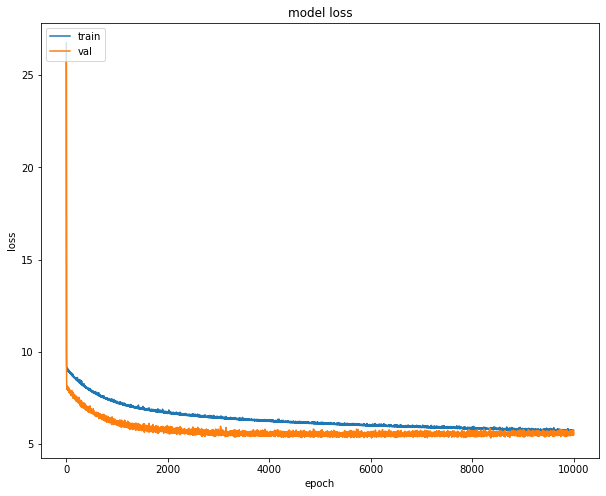

<IPython.core.display.Javascript object>

In [206]:
plt.figure(figsize=(10, 8))
plt.plot(wm_model_hist.history["loss"])
plt.plot(wm_model_hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()